prepare

In [124]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
import re
import random

In [126]:
# Import series of helper functions for the notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves

In [127]:
# Check GPU

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Read dataset

In [128]:
df_data=pd.read_csv('data_1A.csv')
df_data = df_data.drop(columns=['Unnamed: 0'])
df_data.head(10)

,text,label
0,Tuberculous peritonitis: a study comparing cir...,cardiovascular diseases
1,Clinical and Doppler echocardiographic follow-...,general pathological conditions
2,Pulmonary embolism presenting as exercise-indu...,nervous system diseases
3,Pancreatitis. Pancreatitis is a common but rat...,cardiovascular diseases
4,Xeroderma pigmentosum: review and report of a ...,general pathological conditions
5,Brain abscess associated with congenital pulmo...,general pathological conditions
6,Implication of specific DQB1 alleles in geneti...,general pathological conditions
7,Primary adenocarcinoma of the bladder: favorab...,digestive system diseases
8,Cancer surveillance in ulcerative colitis. Dur...,digestive system diseases
9,Activated protooncogenes in human lung tumors ...,digestive system diseases


encode

In [129]:
#Encoding Categorical to Numeric 

label_encode={"label": {"cardiovascular diseases":0,"general pathological conditions" :1,"nervous system diseases":2,
                       "digestive system diseases":3, "neoplasms":4}}
df_data=df_data.replace(label_encode)

cleansing text

In [130]:
def cleansing(df_data):
    df_clean = df_data.str.lower()
    df_clean = [re.sub(r'[^\w\s]', '', i) for i in df_clean]
    df_clean = [re.sub(r'\s+', ' ', i) for i in df_clean]
    return df_clean

In [131]:
df_data['clean_text'] = cleansing(df_data['text'])
df_data.drop('text', axis=1, inplace=True)
df_data.head(5)

,label,clean_text
0,0,tuberculous peritonitis a study comparing cirr...
1,1,clinical and doppler echocardiographic followu...
2,2,pulmonary embolism presenting as exerciseinduc...
3,0,pancreatitis pancreatitis is a common but rath...
4,1,xeroderma pigmentosum review and report of a c...


Exploratory Data Analysis

In [132]:
# Check unique

unique_sentiments = df_data['label'].unique()
print(unique_sentiments)

[0 1 2 3 4]


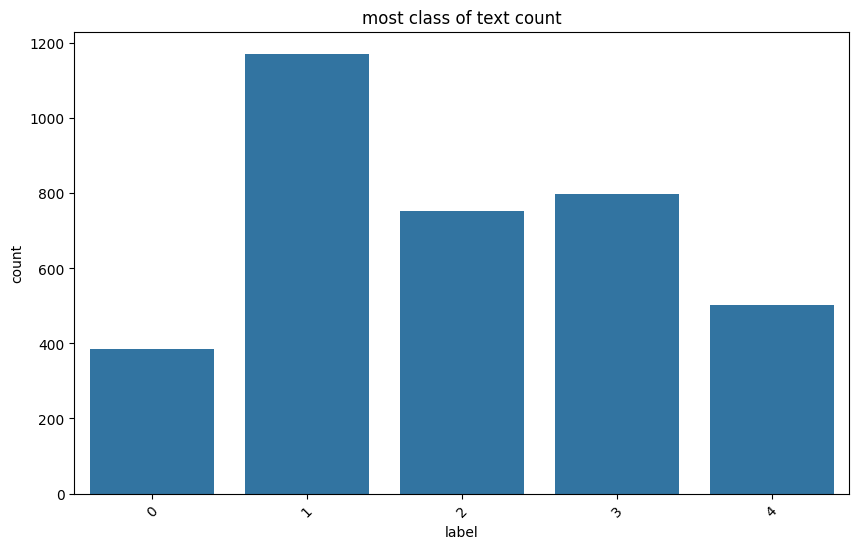

In [133]:
# Check the distribution of classes

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df_data)
plt.xticks(rotation=45)
plt.title('most class of text count')
plt.show()

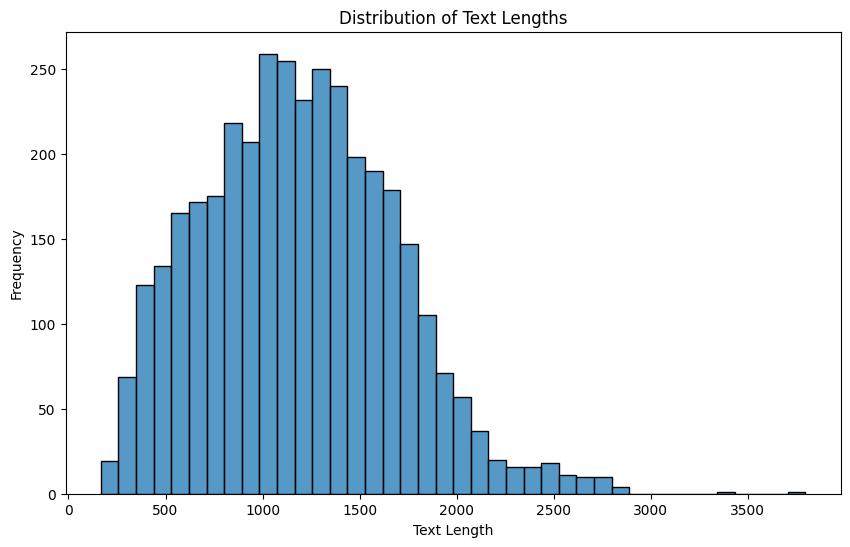

In [134]:
# Check the distribution of text lengths

df_data['text_length'] = df_data['clean_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df_data['text_length'])
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

In [135]:
# visualize some random training examples
# create random indexes not higher than the total number of samples

random_index = random.randint(0, len(df_data) - 3)
for row in df_data[["clean_text", "label"]].iloc[random_index:random_index+3].itertuples():
    _, clean_text, label = row
    sentiment_label = ""
    if label == 0:
        sentiment_label = "(cardiovascular diseases)"
    elif label == 1:
        sentiment_label = "(general pathological conditions)"
    elif label == 2:
        sentiment_label = "(nervous system diseases)"
    elif label == 3:
        sentiment_label = "(digestive system diseases)"
    elif label == 4:
        sentiment_label = "(neoplasms)"
    
    print(f"Target: {label} {sentiment_label}")
    print(f"text:\n{clean_text}\n")
    print("---\n")

Target: 0 (cardiovascular diseases)
text:
anal sphincter function after intersphincteric resection and stapled ileal pouchanal anastomosis this study was done to determine the effect of the direct ileal pouchanal anastomosis upon pressure and sensory components of the anal canal and ileal pouch these findings were related to postoperative continence thirtythree patients with ileal pouchanal anastomosis 25 continent eight with episodic minor incontinence were studied 3 03 and 25 5 months after ileostomy takedown the maximum resting pressure in the anal canal was significantly lower in patients with an imperfect result 35 5 mm hg than in continent patients 44 5 mm hg p less than 005 postoperatively the maximum squeeze anal pressure was slightly greater in continent than in incontinent patients 99 8 mm hg vs 87 7 mm hg p greater than 005 the postoperative rectoileoanal inhibitory reflex was present in 27 percent the linear correlation between strength of rectal ileal distension and depth 

split test

In [136]:
from sklearn.model_selection import train_test_split

In [137]:
x_train, x_test, y_train, y_test = train_test_split(df_data['clean_text'].to_numpy(),df_data['label'].to_numpy(),
    test_size=0.2,
    random_state=42,
    stratify=df_data['label']
)

In [138]:
# Check the lengths

len(x_train), len(x_test), len(y_train), len(y_test)

(2887, 722, 2887, 722)

In [139]:
# View the sample training sentences and their labels

x_train[:3], y_train[:3]

(array(['polycystic ovary syndrome polycystic ovary syndrome is a disorder of unknown cause characterized by anovulation hyperandrogenism and gonadotropin secretory abnormalities producing oligoovulation or anovulation hyperinsulinemia and insulin resistance are important features of this syndrome because other causes of androgen excess may produce similar clinical and biochemical findings pco remains a diagnosis of exclusion treatment is directed toward relieving symptoms of hyperandrogenemia in order to stimulate ovulation correcting obesity and inducing regular menses to reduce the risk of endometrial cancer ',
        'coronary dynamics and mental arithmetic stress in humans incidence and mechanisms of psychological stressinduced myocardial ischemia were investigated in a population of 63 patients using mental arithmetic fifty subjects group 1 were selected as a consecutive population of ischemic patients with electrocardiographic documentation of ischemia at rest on effort or both

Text vectorization (tokenization)

In [140]:
# Find average number of tokens words in training
round(sum([len(i.split()) for i in x_train])/len(x_train))

178

In [141]:
from tensorflow.keras.layers import TextVectorization

# Setup text vectorization with custom variables
max_vocab_length = 68000 # max number of words in vocabulary
max_length = 50 # max length 

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [142]:
# Fit the text vectorizer to the training text

x_train = np.array(x_train)
text_vectorizer.adapt(x_train)

In [143]:
# Create sample sentence and tokenize it

sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[    1,     7,     1,     5, 18613, 12084,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int64)>

In [144]:
# Choose a random sentence from the training dataset and tokenize it

random_sentence = random.choice(x_train)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
ki67 immunostaining in uveal melanoma the effect of preenucleation radiotherapy the reactivity of 33 choroidal and ciliary body melanomas with monoclonal antibody ki67 which recognizes a proliferation associated nuclear antigen has been assessed and compared with clinicopathologic parameters in 23 cases 8 gy irradiation was given 2 days before enucleation nonirradiated melanomas had a significantly higher proliferation rate as defined by staining with monoclonal antibody ki67 as compared with irradiated tumors p 0007 similarly a strong relationship was found between preenucleation irradiation and low mitotic activity p 0001 there was no significant correlation between the presence of ki67positive nuclei and histologic classification largest tumor diameter localization of the tumor age sex scleral invasion pigmentation and lymphocytic infiltration the relevance of ki67 immunohistochemistry for the assessment of the life prognosis of patients with uveal melanoma has to be 

<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[ 3070,  4458,     5,  8287,   904,     2,   145,     3, 12560,
         1289,     2,  1334,     3,   620,  8007,     4, 11174,   461,
         3332,     6,   850,   625,  3070,    71, 10008,     7,  1081,
           57,  1012,   756,    78,    61,   545,     4,    87,     6,
         2608,   848,     5,   456,    47,   201,  2961,  1253,    10,
          510,    55,   156,   158, 14008]], dtype=int64)>

Creating an Embedding using an Embedding Layer

In [145]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding") 

embedding

In [146]:
# Get a random sentence from training set

random_sentence = random.choice(x_train)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
morphologic comparison of patients with mitral valve prolapse who died suddenly with patients who died from severe valvular dysfunction or other conditions clinical and necropsy findings are described in 56 patients with mitral valve prolapse 15 patients aged 16 to 69 years mean 39 died suddenly and mitral valve prolapse was the only cardiac condition found at necropsy hereafter called isolated mitral valve prolapse the remaining 41 patients had other conditions that were capable of being fatal of the latter 41 patients 7 aged 17 to 59 years mean 45 had associated congenital heart disease and 34 patients aged 17 to 70 years mean 52 had no associated congenital cardiac abnormalities compared with the 34 patients without associated congenital heart disease and with nonmitral valve prolapse conditions capable in themselves of being fatal the 15 patients who died suddenly with isolated mitral valve prolapse were younger mean age 39 17 versus 52 15 years p 001 more often wome

<tf.Tensor: shape=(1, 50, 128), dtype=float32, numpy=
array([[[-0.03485414,  0.0316172 , -0.03001304, ...,  0.04393971,
         -0.00663139,  0.00551914],
        [-0.011117  , -0.01811664, -0.03577063, ...,  0.03116608,
         -0.01140321,  0.00645112],
        [-0.00826411, -0.04914596, -0.0444895 , ..., -0.00605583,
         -0.00125401, -0.0453322 ],
        ...,
        [-0.00919495, -0.00564403,  0.04084707, ..., -0.03913001,
          0.04427688, -0.00545119],
        [-0.0103081 , -0.0445325 , -0.03841473, ..., -0.04280178,
          0.0086251 ,  0.02691129],
        [-0.03164423,  0.04556025,  0.01426282, ..., -0.02745411,
         -0.04582199, -0.04233295]]], dtype=float32)>

In [147]:
# Check out a single token's embedding

sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.03485414,  0.0316172 , -0.03001304,  0.03695089,  0.00579267,
       -0.03658779,  0.03925829, -0.03325259, -0.00430704,  0.04855562,
        0.00156455, -0.02215174,  0.0119977 , -0.00164719, -0.04798877,
        0.02201115,  0.0210502 ,  0.02731686,  0.04591275, -0.01223927,
       -0.03895211,  0.04454329,  0.00508023,  0.02981718,  0.01206796,
       -0.02389661,  0.02902788, -0.00986117,  0.00720428, -0.0439676 ,
        0.02623334,  0.01025932,  0.01893887,  0.0335275 ,  0.04739146,
        0.01029975, -0.00991435,  0.00252285,  0.00749841,  0.04620396,
        0.02532549,  0.029617  , -0.0284681 ,  0.0066876 , -0.00761294,
        0.03034223, -0.01393704,  0.03287375, -0.04057621, -0.03503274,
        0.01812066, -0.0294123 ,  0.04454526,  0.02948851, -0.03007358,
       -0.0464906 ,  0.0151955 , -0.047252  ,  0.00175289, -0.04014121,
        0.00544752,  0.01807919,  0.04678984, -0.00653519, -0.0432974 ,
       -0.007654

LSTM Model

In [148]:
# Set random seed and embedding layer
tf.random.set_seed(42)

from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)

# x = layers.LSTM
x = layers.LSTM(64)(x)

# x = layers.Dense
outputs = layers.Dense(5, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs, name="model_LSTM")

In [149]:
# Compile model
model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [150]:
# Get a summary of the model
model.summary()

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 50)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 50, 128)           8704000   
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 8,753,733
Trainable params: 8,753,733
Non-trainable params: 0
______________________________________________

In [151]:
# Create ModelCheckpoint callback
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "./best_model.LSTM"
model_checkpoint = ModelCheckpoint(checkpoint_path, 
                                   monitor='val_accuracy', 
                                   save_best_only=True, 
                                   mode='max', 
                                   verbose=1)

In [152]:
# Fit model
SAVE_DIR = "./logs"
model_history = model.fit(x_train,
                          y_train,
                          epochs=5,
                          validation_data=(x_test, y_test),
                          callbacks=[create_tensorboard_callback(SAVE_DIR, "LSTM_model"), model_checkpoint])

Saving TensorBoard log files to: ./logs/LSTM_model/20240222-160630
Epoch 1/5


91/91 [==============================] - ETA: 0s - loss: 1.5494 - accuracy: 0.3187
Epoch 1: val_accuracy improved from -inf to 0.32548, saving model to .\best_model.LSTM


INFO:tensorflow:Assets written to: .\best_model.LSTM\assets


INFO:tensorflow:Assets written to: .\best_model.LSTM\assets


91/91 [==============================] - 5s 46ms/step - loss: 1.5494 - accuracy: 0.3187 - val_loss: 1.5164 - val_accuracy: 0.3255
Epoch 2/5
87/91 [===========================>..] - ETA: 0s - loss: 1.1847 - accuracy: 0.5312
Epoch 2: val_accuracy improved from 0.32548 to 0.46814, saving model to .\best_model.LSTM


INFO:tensorflow:Assets written to: .\best_model.LSTM\assets


INFO:tensorflow:Assets written to: .\best_model.LSTM\assets


91/91 [==============================] - 4s 47ms/step - loss: 1.1762 - accuracy: 0.5345 - val_loss: 1.3123 - val_accuracy: 0.4681
Epoch 3/5
90/91 [============================>.] - ETA: 0s - loss: 0.6982 - accuracy: 0.7656
Epoch 3: val_accuracy improved from 0.46814 to 0.47230, saving model to .\best_model.LSTM


INFO:tensorflow:Assets written to: .\best_model.LSTM\assets


INFO:tensorflow:Assets written to: .\best_model.LSTM\assets


91/91 [==============================] - 4s 41ms/step - loss: 0.6980 - accuracy: 0.7658 - val_loss: 1.4897 - val_accuracy: 0.4723
Epoch 4/5
89/91 [============================>.] - ETA: 0s - loss: 0.3776 - accuracy: 0.8901
Epoch 4: val_accuracy did not improve from 0.47230
91/91 [==============================] - 1s 14ms/step - loss: 0.3773 - accuracy: 0.8905 - val_loss: 1.6815 - val_accuracy: 0.4418
Epoch 5/5
89/91 [============================>.] - ETA: 0s - loss: 0.2611 - accuracy: 0.9242
Epoch 5: val_accuracy did not improve from 0.47230
91/91 [==============================] - 1s 13ms/step - loss: 0.2640 - accuracy: 0.9228 - val_loss: 1.9438 - val_accuracy: 0.4640


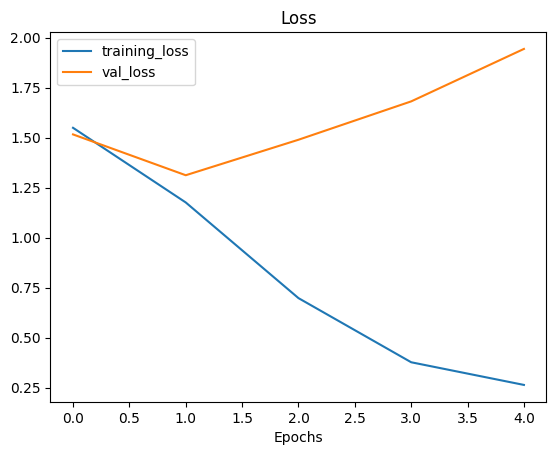

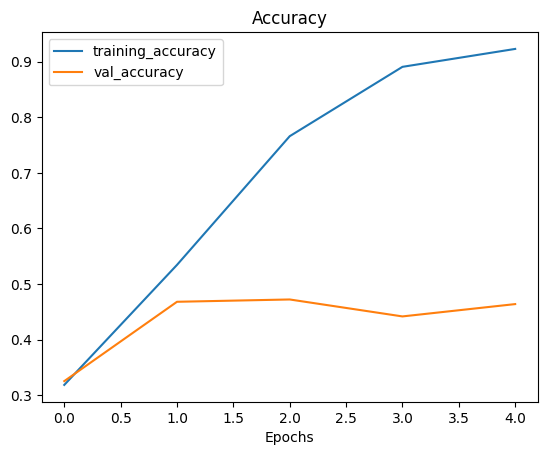

In [153]:
plot_loss_curves(model_history)
plt.show()

In [154]:
# Make predictions on the validation data

model_pred_probs = model.predict(x_test)
model_pred_probs.shape, model_pred_probs[:10]

23/23 [==============================] - 0s 4ms/step


((722, 5),
 array([[6.3128592e-03, 5.9376544e-01, 9.7373566e-03, 3.6125541e-01,
         2.8928919e-02],
        [3.9552625e-02, 8.6823058e-01, 3.0158930e-02, 4.9746174e-02,
         1.2311639e-02],
        [2.5695148e-03, 2.0467643e-01, 7.6275450e-01, 2.3601418e-03,
         2.7639434e-02],
        [1.8081169e-03, 1.4622959e-01, 8.2863027e-01, 2.6925120e-03,
         2.0639431e-02],
        [7.2420719e-03, 7.0019327e-02, 3.9918195e-03, 8.9377522e-01,
         2.4971487e-02],
        [6.3544107e-03, 3.5758469e-02, 9.4230413e-01, 1.8561308e-03,
         1.3726785e-02],
        [6.7061363e-03, 8.4193209e-03, 9.7539437e-01, 1.0335927e-03,
         8.4466655e-03],
        [5.1085189e-02, 4.6087003e-01, 1.1984775e-01, 5.9765305e-02,
         3.0843171e-01],
        [8.3730631e-03, 3.8916659e-01, 5.5884814e-01, 6.0608778e-03,
         3.7551343e-02],
        [8.7778427e-04, 1.4014914e-02, 7.4965350e-04, 9.8296779e-01,
         1.3897422e-03]], dtype=float32))

In [155]:
# Convert prediction probabilities to prediction classes

model_preds = tf.squeeze(tf.round(model_pred_probs))
model_preds[:10]

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)>

In [156]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):

    # Convert one-hot encoded labels to class labels
    y_true_classes = np.argmax(y_true, axis=1) if len(y_true.shape) > 1 else y_true
    y_pred_classes = np.argmax(y_pred, axis=1) if len(y_pred.shape) > 1 else y_pred

    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true_classes, y_pred_classes) * 100
    
    # Calculate model precision, recall, and f1 score using "weighted average"
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [157]:
model_results = calculate_results(y_true=y_test, y_pred=model_preds)
model_results

{'accuracy': 45.15235457063712,
 'precision': 0.4457701534473915,
 'recall': 0.4515235457063712,
 'f1': 0.4431337435646222}

Machine learning - Naive Bayes

In [158]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_ml = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_ml.fit(X=x_train, 
            y=y_train);

In [159]:
# Evaluate baseline on validation dataset

model_ml.score(X=x_test,
              y=y_test)

0.4362880886426593

In [160]:
# Make predictions
ml_preds = model_ml.predict(x_test)
ml_preds

array([1, 1, 2, 2, 3, 2, 2, 1, 1, 3, 1, 1, 3, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1,
       1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1,
       1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 2, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 3, 1, 1, 1, 3, 2, 1, 1, 1, 1, 2,

In [161]:
# Calculate baseline results
ml_preds = calculate_results(y_true=y_test,
                                     y_pred=ml_preds)
ml_preds

c:\Users\kmnvz\anaconda3\envs\my_env\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 43.62880886426593,
 'precision': 0.44259754821659436,
 'recall': 0.4362880886426593,
 'f1': 0.3679313383347805}

In [162]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model("./best_model.LSTM")

# Evaluate the best model on the test data
evaluation_results = best_model.evaluate(x_test, y_test)

# Print the evaluation results
print("Test Accuracy:", evaluation_results[1])
print("Test Loss:", evaluation_results[0])

23/23 [==============================] - 0s 5ms/step - loss: 1.4897 - accuracy: 0.4723
Test Accuracy: 0.47229915857315063
Test Loss: 1.4897369146347046
